# Preprocessing

## Load Data

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Load the dataset
df = pd.read_csv('processed_data.csv')

cpu


## Feature Selection

In [23]:
features = [
    'GENDER', 'AGE RANGE OF ENROLLED STUDENT', 'BENEFIT DISCOUNTS', 'STUDY MODE',
    'SHIFT/SCHEDULE', 'ENROLLMENT',
    'PROGRAM/MAJOR', 'DEPARTMENT'
]

target = 'NUMBER OF ENROLLED COURSES'

corr_df = df[features + [target]].copy()
# Compute correlations with the target
correlations = corr_df.corr(numeric_only=True)[target].abs().sort_values(ascending=False)

print("Correlation of Features with Target (COURSE_CLASS):")
print(correlations)


Correlation of Features with Target (COURSE_CLASS):
NUMBER OF ENROLLED COURSES       1.000000
STUDY MODE                       0.142876
AGE RANGE OF ENROLLED STUDENT    0.076611
ENROLLMENT                       0.046427
PROGRAM/MAJOR                    0.025488
DEPARTMENT                       0.024340
SHIFT/SCHEDULE                   0.023768
BENEFIT DISCOUNTS                0.015782
GENDER                           0.006360
Name: NUMBER OF ENROLLED COURSES, dtype: float64


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# 1. Select features and target
features = [
    'GENDER', 'AGE RANGE OF ENROLLED STUDENT', 'BENEFIT DISCOUNTS', 'STUDY MODE',
    'SHIFT/SCHEDULE', 'ENROLLMENT',
    'PROGRAM/MAJOR', 'DEPARTMENT'
]
target = 'NUMBER OF ENROLLED COURSES'

X = df[features]
y = df[target]

# 4. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(len(X_train), len(X_test))

Scores = {}


29267 7317


## Define Classifier Head

In [25]:
from sklearn.base import BaseEstimator, ClassifierMixin

class RoundOffRegressorClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_regressor):
        self.base_regressor = base_regressor

    def fit(self, X, y):
        self.base_regressor.fit(X, y)
        return self

    def predict(self, X):
        preds = self.base_regressor.predict(X)
        return np.round(preds).astype(int)




# Models

## Regressor

### Linear

In [26]:
from sklearn.linear_model import LinearRegression

model = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])
# 5. Train model
model.fit(X_train, y_train)

# 6. Predict and evaluate
y_pred = model.predict(X_test)

print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

Mean Squared Error: 0.9532866208554319
R² Score: 0.028833192975754263


### Ridge

In [27]:
from sklearn.linear_model import Ridge

# Ridge regression pipeline
ridge_model = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('regressor', Ridge(alpha=1.0))  # You can tune alpha
])

# Train Ridge model
ridge_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_ridge = ridge_model.predict(X_test)

print("Ridge Regression")
print("MSE:", mean_squared_error(y_test, y_pred_ridge))
print("R² Score:", r2_score(y_test, y_pred_ridge))


Ridge Regression
MSE: 0.9532866248794746
R² Score: 0.028833188876235094


### Lasso

In [28]:
from sklearn.linear_model import Lasso

# Lasso regression pipeline
lasso_model = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('regressor', Lasso(alpha=0.1, max_iter=10000))  # You can tune alpha
])

# Train Lasso model
lasso_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_lasso = lasso_model.predict(X_test)
print("Lasso Regression")
print("MSE:", mean_squared_error(y_test, y_pred_lasso))
print("R² Score:", r2_score(y_test, y_pred_lasso))


Lasso Regression
MSE: 0.971665196132071
R² Score: 0.010109902541811211


## Classification

In [29]:
from sklearn.metrics import classification_report, accuracy_score

### Linear + Classifier

In [30]:
model = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])
# 5. Train model
model.fit(X_train, y_train)

# 6. Predict and evaluate
y_pred = model.predict(X_test)
y_pred_class = np.floor(y_pred).astype(int)
linear_score = accuracy_score(y_test, y_pred_class)
Scores['Linear Regression'] = linear_score

print("Linear Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_class))
print("Classification Report:")
print(classification_report(y_test, y_pred_class))

Linear Regression
Accuracy: 0.3131064643979773
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       415
           1       0.34      0.67      0.45      2262
           2       0.27      0.37      0.31      2092
           3       0.00      0.00      0.00      2313
           4       0.00      0.00      0.00       231
           5       0.00      0.00      0.00         4

    accuracy                           0.31      7317
   macro avg       0.10      0.17      0.13      7317
weighted avg       0.18      0.31      0.23      7317



d:\Dev\python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Dev\python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Dev\python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Ridge + Classifier

In [31]:
from sklearn.linear_model import Ridge

# Ridge regression pipeline
ridge_model = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('regressor', RoundOffRegressorClassifier(Ridge(alpha=1.0)))
])

# Train Ridge model
ridge_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_ridge = ridge_model.predict(X_test)
ri_score = accuracy_score(y_test, y_pred_ridge)
Scores['Ridge Regression'] = ri_score

# Evaluate
print("Ridge Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_ridge))
print(classification_report(y_test, y_pred_ridge))


Ridge Regression
Accuracy: 0.2868662019953533
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       415
           1       0.00      0.00      0.00      2262
           2       0.29      1.00      0.44      2092
           3       0.82      0.00      0.01      2313
           4       0.00      0.00      0.00       231
           5       0.00      0.00      0.00         4

    accuracy                           0.29      7317
   macro avg       0.18      0.17      0.08      7317
weighted avg       0.34      0.29      0.13      7317



d:\Dev\python\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
d:\Dev\python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Dev\python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Dev\python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWa

### Lasso + Classfier

In [32]:
from sklearn.linear_model import Lasso

# Lasso regression pipeline
lasso_model = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('regressor', RoundOffRegressorClassifier(Lasso(alpha=0.1, max_iter=10000)))
])

# Train Lasso model
lasso_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_lasso = lasso_model.predict(X_test)
la_score = accuracy_score(y_test, y_pred_lasso)
Scores['Lasso Regression'] = la_score
# Evaluate
print("Lasso Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_lasso))
print(classification_report(y_test, y_pred_lasso))


Lasso Regression
Accuracy: 0.2859095257619243
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       415
           1       0.00      0.00      0.00      2262
           2       0.29      1.00      0.44      2092
           3       0.00      0.00      0.00      2313
           4       0.00      0.00      0.00       231
           5       0.00      0.00      0.00         4

    accuracy                           0.29      7317
   macro avg       0.05      0.17      0.07      7317
weighted avg       0.08      0.29      0.13      7317



d:\Dev\python\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
d:\Dev\python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Dev\python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Dev\python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWa

## Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression pipeline
log_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Required for logistic regression
    ('classifier', LogisticRegression(multi_class='multinomial', max_iter=1000))
])

# Train Logistic Regression model
log_pipeline.fit(X_train, y_train)
# Predict and evaluate
y_pred_log = log_pipeline.predict(X_test)
lg_score = accuracy_score(y_test, y_pred_log)
Scores['Logistic Regression'] = lg_score
# Evaluate
print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

d:\Dev\python\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression
Accuracy: 0.3676370097034304
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       415
           1       0.37      0.50      0.42      2262
           2       0.30      0.20      0.24      2092
           3       0.40      0.49      0.44      2313
           4       0.00      0.00      0.00       231
           5       0.00      0.00      0.00         4

    accuracy                           0.37      7317
   macro avg       0.18      0.20      0.18      7317
weighted avg       0.33      0.37      0.34      7317



d:\Dev\python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Dev\python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Dev\python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Random Forest Classifier

In [34]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest pipeline
rf_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Required for Random Forest
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train Random Forest model
rf_pipeline.fit(X_train, y_train)
# Predict and evaluate
y_pred_rf = rf_pipeline.predict(X_test)
rf_score = accuracy_score(y_test, y_pred_rf)
Scores['Random Forest'] = rf_score
# Evaluate
print("Random Forest")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest
Accuracy: 0.3922372557058904
              precision    recall  f1-score   support

           0       0.23      0.14      0.18       415
           1       0.41      0.43      0.42      2262
           2       0.33      0.33      0.33      2092
           3       0.45      0.50      0.47      2313
           4       0.10      0.03      0.05       231
           5       0.00      0.00      0.00         4

    accuracy                           0.39      7317
   macro avg       0.25      0.24      0.24      7317
weighted avg       0.38      0.39      0.38      7317



d:\Dev\python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Dev\python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Dev\python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## XGBoost

In [35]:
from xgboost import XGBClassifier

# XGBoost pipeline
xgb_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Required for XGBoost
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42,num_class=len(y.unique())))
])

# Train XGBoost model
xgb_pipeline.fit(X_train, y_train)
# Predict and evaluate
y_pred_xgb = xgb_pipeline.predict(X_test)
xg_score = accuracy_score(y_test, y_pred_xgb)
Scores['XGBoost'] = xg_score
# Evaluate
print("XGBoost")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))



d:\Dev\python\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:55:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost
Accuracy: 0.43433100997676644
              precision    recall  f1-score   support

           0       0.37      0.11      0.17       415
           1       0.44      0.52      0.48      2262
           2       0.35      0.33      0.34      2092
           3       0.49      0.55      0.52      2313
           4       0.00      0.00      0.00       231
           5       0.00      0.00      0.00         4

    accuracy                           0.43      7317
   macro avg       0.28      0.25      0.25      7317
weighted avg       0.41      0.43      0.42      7317



d:\Dev\python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Dev\python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Dev\python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## ANN

In [36]:

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR



# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [37]:
class DeepNN(nn.Module):
    def __init__(self, input_dim, num_classes, apply_softmax=False):
        super(DeepNN, self).__init__()
        self.apply_softmax = apply_softmax
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        if self.apply_softmax:
            return F.softmax(x, dim=1)
        return x


In [38]:
input_dim = X_train.shape[1]
num_classes = len(y.unique())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Initialize model, loss function, and optimizer
model = DeepNN(input_dim=input_dim, num_classes=num_classes, apply_softmax=False).to(device)
criterion = nn.CrossEntropyLoss()  # This expects raw logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()  # Step the scheduler after each epoch
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")
# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        out = model(xb)
        _, predicted = torch.max(out, 1)
        total += yb.size(0)
        correct += (predicted == yb).sum().item()
accuracy = correct / total
Scores['DeepNN'] = accuracy
print("Deep Neural Network")
print(f"Test Accuracy: {accuracy:.4f}")


cpu
Epoch 1/100, Loss: 624.5196
Epoch 2/100, Loss: 605.0907
Epoch 3/100, Loss: 602.1715
Epoch 4/100, Loss: 600.4376
Epoch 5/100, Loss: 597.9490
Epoch 6/100, Loss: 595.3400
Epoch 7/100, Loss: 592.9342
Epoch 8/100, Loss: 591.9579
Epoch 9/100, Loss: 592.0793
Epoch 10/100, Loss: 590.7282
Epoch 11/100, Loss: 589.6889
Epoch 12/100, Loss: 587.7512
Epoch 13/100, Loss: 587.7199
Epoch 14/100, Loss: 587.2996
Epoch 15/100, Loss: 587.0756
Epoch 16/100, Loss: 586.5853
Epoch 17/100, Loss: 585.8421
Epoch 18/100, Loss: 585.3849
Epoch 19/100, Loss: 585.9533
Epoch 20/100, Loss: 586.3466
Epoch 21/100, Loss: 585.0913
Epoch 22/100, Loss: 584.9484
Epoch 23/100, Loss: 584.5868
Epoch 24/100, Loss: 584.5635
Epoch 25/100, Loss: 584.4723
Epoch 26/100, Loss: 584.2038
Epoch 27/100, Loss: 584.1922
Epoch 28/100, Loss: 584.2974
Epoch 29/100, Loss: 583.9722
Epoch 30/100, Loss: 583.8020
Epoch 31/100, Loss: 584.3173
Epoch 32/100, Loss: 584.2113
Epoch 33/100, Loss: 584.6575
Epoch 34/100, Loss: 584.0411
Epoch 35/100, Loss:

## Model Comparison

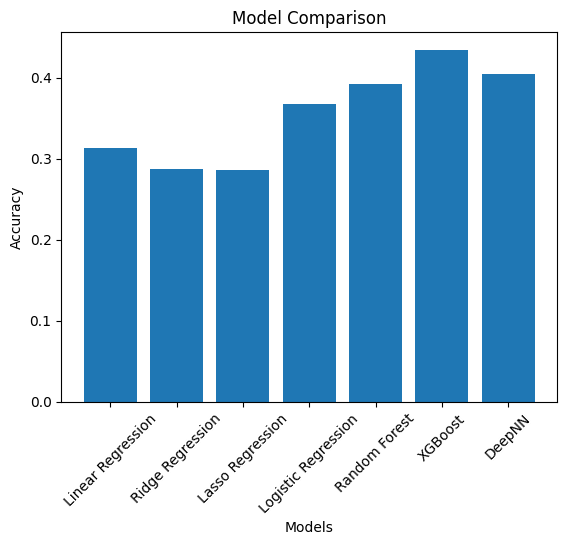

In [39]:
plt.Figure(figsize=(12, 5))
plt.bar(Scores.keys(), Scores.values())
plt.ylabel('Accuracy')
plt.xlabel('Models')
plt.title('Model Comparison')
plt.xticks(rotation=45)
plt.show()

## Ensemble

In [40]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

# Define individual model pipelines (with same preprocessing)
log_model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000, multi_class='multinomial'))
])

rf_model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

xgb_model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier(
        objective='multi:softmax',
        num_class=len(y.unique()),
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    ))
])

# Ensemble Voting Classifier
ensemble_model = VotingClassifier(
    estimators=[
        ('logreg', log_model),
        ('rf', rf_model),
        ('xgb', xgb_model)
    ],
    voting='hard'  # use 'soft' for probabilities if supported
)

# Train and evaluate
ensemble_model.fit(X_train, y_train)
y_pred_ensemble = ensemble_model.predict(X_test)

print("Ensemble Accuracy:", accuracy_score(y_test, y_pred_ensemble))
print("Classification Report:")
print(classification_report(y_test, y_pred_ensemble))


d:\Dev\python\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
d:\Dev\python\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:18:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Ensemble Accuracy: 0.42093754270876044
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.12      0.16       415
           1       0.41      0.59      0.48      2262
           2       0.35      0.25      0.29      2092
           3       0.49      0.51      0.50      2313
           4       0.00      0.00      0.00       231
           5       0.00      0.00      0.00         4

    accuracy                           0.42      7317
   macro avg       0.25      0.24      0.24      7317
weighted avg       0.40      0.42      0.40      7317



d:\Dev\python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Dev\python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Dev\python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Finding Correlation

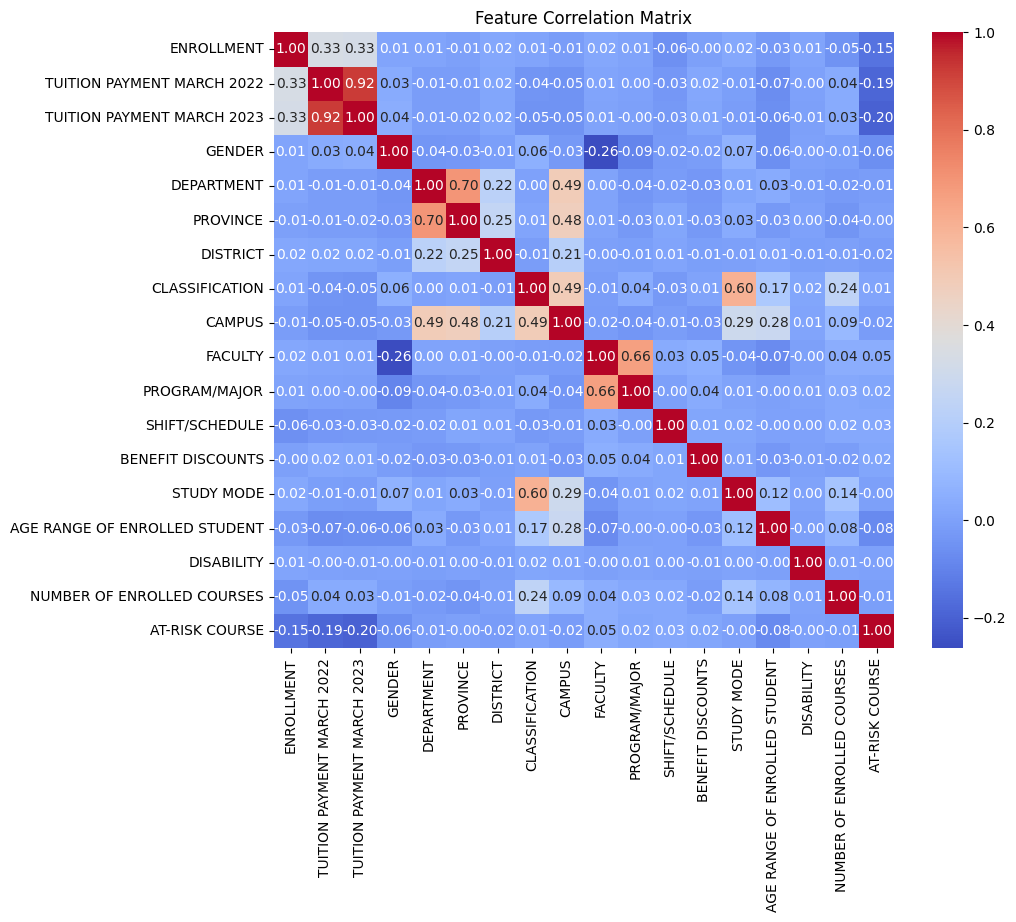

In [41]:
# Ensure only numeric features are used
numeric_df = df.select_dtypes(include=[np.number])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot it for reference
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

In [43]:
# Sum absolute correlations for each feature (excluding self-correlation)
corr_sums = corr_matrix.abs().sum(axis=1) - 1  # subtract 1 for self-correlation

# Sort to find most 'connected' features
sorted_corr = corr_sums.sort_values(ascending=False)
print("Features most correlated with other numeric features:")
print(sorted_corr)


Features most correlated with other numeric features:
CAMPUS                           2.591641
TUITION PAYMENT MARCH 2023       1.804974
CLASSIFICATION                   1.803353
TUITION PAYMENT MARCH 2022       1.793102
PROVINCE                         1.692367
DEPARTMENT                       1.675508
STUDY MODE                       1.404580
FACULTY                          1.300251
AGE RANGE OF ENROLLED STUDENT    1.127483
ENROLLMENT                       1.074932
PROGRAM/MAJOR                    1.008336
NUMBER OF ENROLLED COURSES       0.870695
AT-RISK COURSE                   0.866011
GENDER                           0.847174
DISTRICT                         0.838061
SHIFT/SCHEDULE                   0.348346
BENEFIT DISCOUNTS                0.336492
DISABILITY                       0.083986
dtype: float64
